In [36]:
is_colab = False
try:
    import torch  
    print('Module torch was installed')
except ImportError:    
    print("Installinng torch 1.8.1")
    !pip install -q torch==1.8.1
try:
    import torchvision  
    print('Module torchvision was installed')
except ImportError:    
    print("Installinng torchvision 0.4.0")
    !pip install -q torchvision==0.4.0
    
try:
    import qiskit  
    print('Module qiskit was installed')
except ImportError:    
    print("Installinng qiskit 0.29.0")
    !pip install -q qiskit==0.29.0
import sys
if is_colab:
    !pip install pylatexenc
    !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=11sS4bjxUiDC6jXlvpns_vobQScoSvIxP' -O codes2.zip
    !unzip codes2.zip
    sys.path.append('/content/libs/')

#define parameter
input_data_num = 100
qubit_num = 3
is_generate_data = True

SyntaxError: invalid syntax (<ipython-input-36-3446f75abbe2>, line 22)

In [16]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import sys
import functools
from qiskit import  QuantumCircuit, ClassicalRegister
from qiskit import Aer, execute
from qiskit.circuit import Qubit
import math

from circuit.lib_qiskit_commons import *
from circuit.lib_circuit_linner_square import *
from training.lib_dataloader import *

import qiskit

print = functools.partial(print, flush=True)

from qiskit import Aer, execute,IBMQ,transpile
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit.providers.aer.noise import NoiseModel
from qiskit.visualization import *
from qiskit import circuit


####TODO:change simulator,add errors.####
def my_ibmq(circuit,shots,Simulation = True,backend_name='ibmq_essex'):     
    if not Simulation:
        provider = IBMQ.get_provider('ibm-q-academic')
        backend = provider.get_backend(backend_name)
    else:
        backend = Aer.get_backend('qasm_simulator')
    # circuit.save_statevector()
    p_gate = 0.01
    x_error_1 = pauli_error([('X',p_gate), ('I', 1 - p_gate)])
    z_error_1 = pauli_error([('Z',p_gate), ('I', 1 - p_gate)])

    error_1 = x_error_1.compose(z_error_1)
    error_2 = error_1.tensor(error_1)
    error_3 = error_2.tensor(error_1)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_1, ["x"]) # single qubit gate error is applied to x gates
    noise_model.add_all_qubit_quantum_error(error_1, ["z"]) # single qubit gate error is applied to x gates

    noise_model.add_all_qubit_quantum_error(error_2, ["cx"]) # two qubit gate error is applied to cx gates
    noise_model.add_all_qubit_quantum_error(error_2, ["cz"]) # two qubit gate error is applied to cx gates

    noise_model.add_all_qubit_quantum_error(error_3, ["ccx"])

    basis_gates = noise_model.basis_gates
    job_ibm_q = execute(circuit, backend, shots=shots, basis_gates=basis_gates, noise_model=noise_model)
    if not Simulation:
        job_monitor(job_ibm_q)
    result_ibm_q = job_ibm_q.result()

    counts = result_ibm_q.get_counts()
    
    return counts

In [17]:
def fwd_ccx(circuit, b1, b2, b3):
  circuit.h(b3)
  circuit.cx(b1, b3)
  circuit.tdg(b3)
  circuit.cx(b2, b3)
  circuit.t(b3)
  circuit.cx(b1, b3)
  circuit.tdg(b3)
  circuit.cx(b2, b3)
  circuit.t(b2)
  circuit.t(b3)
  circuit.h(b3)
  circuit.swap(b2, b3)
  circuit.cx(b1, b2)
  circuit.t(b1)
  circuit.tdg(b2)
  circuit.cx(b1, b2)
  return circuit


In [18]:
def my_decompose_cz(circuit, b1, b2):
  circuit.swap(b1,b2)
  circuit.cz(b1, b2)
  circuit.swap(b1,b2)
  return circuit

In [19]:
def my_decompose_ccz(circuit, b1, b2, b3, aux1):
  fwd_ccx(circuit, b1, b2, aux1)
  my_decompose_cz(circuit, aux1, b3)
  bwd_ccx2(circuit, b1, b2, aux1)

  return circuit


In [20]:
def my_decompose_cccz(circuit, b1, b2, b3, b4, aux1, aux2):
  fwd_ccx(b1, b2, aux1)
  fwd_ccx(b3, aux1, aux2)
  my_decompose_cz(aux2, b4)
  bwd_ccx1(b3, aux1, aux2)
  bwd_ccx2(b1, b2, aux1)
  return circuit

In [21]:
def ori_bridge(circuit, b1, b2, b3):
  circuit.cx(b2,b3)
  circuit.cx(b1,b2)
  circuit.cx(b2,b3)
  circuit.cx(b1,b2)
  return circuit

In [22]:
def zero_bridge(circuit, b1, b2, b3):
  circuit.cx(b1, b2)
  circuit.cx(b2, b3)
  circuit.cx(b1, b2)
  return circuit

In [23]:
def bwd_ccx1(circuit, b1, b2, b3):
  circuit.swap(b2, b3)
  circuit.h(b3)
  circuit.cx(b1, b3)
  circuit.tdg(b3)
  circuit.cx(b2, b3)
  circuit.t(b3)
  circuit.cx(b1, b3)
  circuit.tdg(b3)
  circuit.cx(b2, b3)
  circuit.t(b2)
  circuit.t(b3)
  circuit.h(b3)
  zero_bridge(circuit,b1, b2, b3)
  circuit.cx(b1, b2)
  circuit.t(b1)
  circuit.tdg(b2)
  circuit.cx(b1, b2)
  return circuit

In [24]:
def bwd_ccx2(circuit, b1, b2, b3):
  circuit.swap(b2, b3)
  circuit.h(b3)
  circuit.cx(b1, b3)
  circuit.tdg(b3)
  circuit.cx(b2, b3)
  circuit.t(b3)
  circuit.cx(b1, b3)
  circuit.tdg(b3)
  circuit.cx(b2, b3)
  circuit.t(b2)
  circuit.t(b3)
  circuit.h(b3)
  ori_bridge(circuit, b1, b2, b3)
  circuit.cx(b1, b2)
  circuit.t(b1)
  circuit.tdg(b2)
  circuit.cx(b1, b2)
  return circuit

In [25]:
def equa(circuit,in_qubits,out_qubit,aux = []):
    for i in range(3):
              circuit.h(in_qubits[i])
              circuit.x(in_qubits[i])
    circuit.barrier()
    #first ccx
    circuit.ccx(in_qubits[0],in_qubits[1],aux[0])    
    #second ccx
    circuit.ccx(in_qubits[2],aux[0],aux[1])
    #third ccx
    circuit.ccx(in_qubits[0],in_qubits[1],aux[0])
    #fourth ccx
    circuit.ccx(in_qubits[2],aux[0],aux[1])    


In [26]:
def func(circuit,in_qubits_list,out_qubit,aux = []):
  i = 0
  j = 0
  for in_qubits in in_qubits_list:
    circuit.h(in_qubits)
    circuit.x(in_qubits)
    circuit.barrier()
    i +=1
  
    # circuit.barrier(in_qubits)
    # circuit.barrier(aux)
  for in_qubits in in_qubits_list:
    #first ccx
    fwd_ccx(circuit,in_qubits[0],in_qubits[1],aux[0])

    #second ccx
    fwd_ccx(circuit,in_qubits[2],aux[0],aux[1])
    circuit.cx(aux[1], out_qubit[j])
    #third ccx
    bwd_ccx1(circuit,in_qubits[0],in_qubits[1],aux[0])
    #fourth ccx
    bwd_ccx2(circuit,in_qubits[2],aux[0],aux[1])   
    j +=1

## define parameters

In [27]:
def sign(input,th = 0.5):
    output = input.new(input.size())
    output[input >= th] = 1
    output[input < th] = -1
    return output

def binary(input,th = 0.5):
    output = input.new(input.size())
    output[input >= th] = 1
    output[input < th] = 0
    return output

def limit(input,high = 1,low = 0):
    output = input.new(input.size())
    output[input >= high] = high
    output[input <= low] = low
    return output

def get_traverse_weight(n):
    sum_mat = []
    flag = "0"+str(n)+"b"
    for i in range(0,int(math.pow(2,n))):
        bit_str = format(i,flag)
        row = []
        for c in bit_str:
            row.append(float(c))
        sum_mat.append(row)
    return sum_mat

## generate datasets

In [28]:
init_weight = torch.tensor([[-1,-1,1,1,1,1,1,1],[1,1,1,1,1,1,-1,-1]],dtype=torch.double)

#get correct result with no error
if is_generate_data:
    normal_data = torch.randn(input_data_num,int(math.pow(2,qubit_num)),dtype=torch.double)
    binary_data = torch.rand(input_data_num,int(math.pow(2,qubit_num)),dtype=torch.double)
    binary_data = binary(binary_data)
    data01 = normal_data /16 + 0.25
    data02 = normal_data /16 + 0.75
    input_data = binary_data*data01 + (1-binary_data)*data02
    input_data = limit(input_data,1,0)
    # input_data = torch.rand(input_data_num,int(math.pow(2,qubit_num)),dtype=torch.double)
    input_data_quantum_matrix = []
    for i in range(input_data_num):
        quantum_matrix =to_quantum_matrix(input_data[i])
        # n1_q_gates,n1_idx =ULayerCircuit.extract_from_weight(init_weight[0])
        input_data_quantum_matrix.append(quantum_matrix[:, 0].view(-1))
    input_data_quantum_matrix = torch.stack(input_data_quantum_matrix)
    # print(input_data_quantum_matrix.t()[0:8].t())
    # print(input_data_quantum_matrix)
    correct_result =torch.mm(init_weight,input_data_quantum_matrix.t())
    correct_result = correct_result*correct_result/math.pow(2,qubit_num)
    # print(correct_result)
    correct_result_binary = sign(correct_result[0]-correct_result[1],0)
    print(correct_result_binary)
    torch.save(input_data, "./liang_random_data.pt")
    torch.save(correct_result_binary.view(-1), "./liang_random_target.pt")
    torch.save(init_weight, "./liang_weight.pt")


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=torch.float64)


##  sgd

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn.functional as F
from torch.nn.parameter import Parameter
from training.lib_qf import BinaryLinearQuantumFirstLAYER
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linner = BinaryLinearQuantumFirstLAYER(8,2,bias=False)
    def forward(self, x):
        x = x.float()
        x = self.linner(x)
        return x


epochs = 1000
input_data = torch.load("./liang_random_data.pt")
target = torch.load("./liang_random_target.pt")
target[target == 1] = 0
target[target == -1] = 1

train_rate = 0.5
input_data_num = input_data.shape[0]
train_num  =  int (input_data_num*train_rate )

model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss() #
loss_list = []
#active batch_normal and drop out.
model.train()
for epoch in range(epochs):
    total_loss = []
    optimizer.zero_grad()
    # Data prepare
    input_data_quantum_matrix = []
    for i in range(train_num):
        quantum_matrix =to_quantum_matrix(input_data[i])
        input_data_quantum_matrix.append(quantum_matrix[:, 0].view(-1))
    input_data_quantum_matrix = torch.stack(input_data_quantum_matrix)

    output = model(input_data_quantum_matrix)
    target = target[0:train_num].view(-1).long()
    loss = loss_func(output, target)
    loss.backward()
    optimizer.step()
    total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    
print('loss:',loss_list[-1])

for itor in model.parameters():
    train_weight =sign(itor,0)
    break

print("train_weight:",train_weight)

# train_weight: tensor([[ 1.,  1.,  1., -1.,  1., -1., -1.,  1.],
#         [ 1., -1., -1., -1., -1., -1., -1., -1.]])

loss: 0.6931474208831787
train_weight: tensor([[-1., -1., -1., -1., -1.,  1.,  1., -1.],
        [-1., -1.,  1., -1.,  1.,  1., -1.,  1.]])


## define forward,including mapping 

tensor([[-1., -1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1., -1., -1.]], dtype=torch.float64)
Result : [0.510986328125, 0.4993896484375]


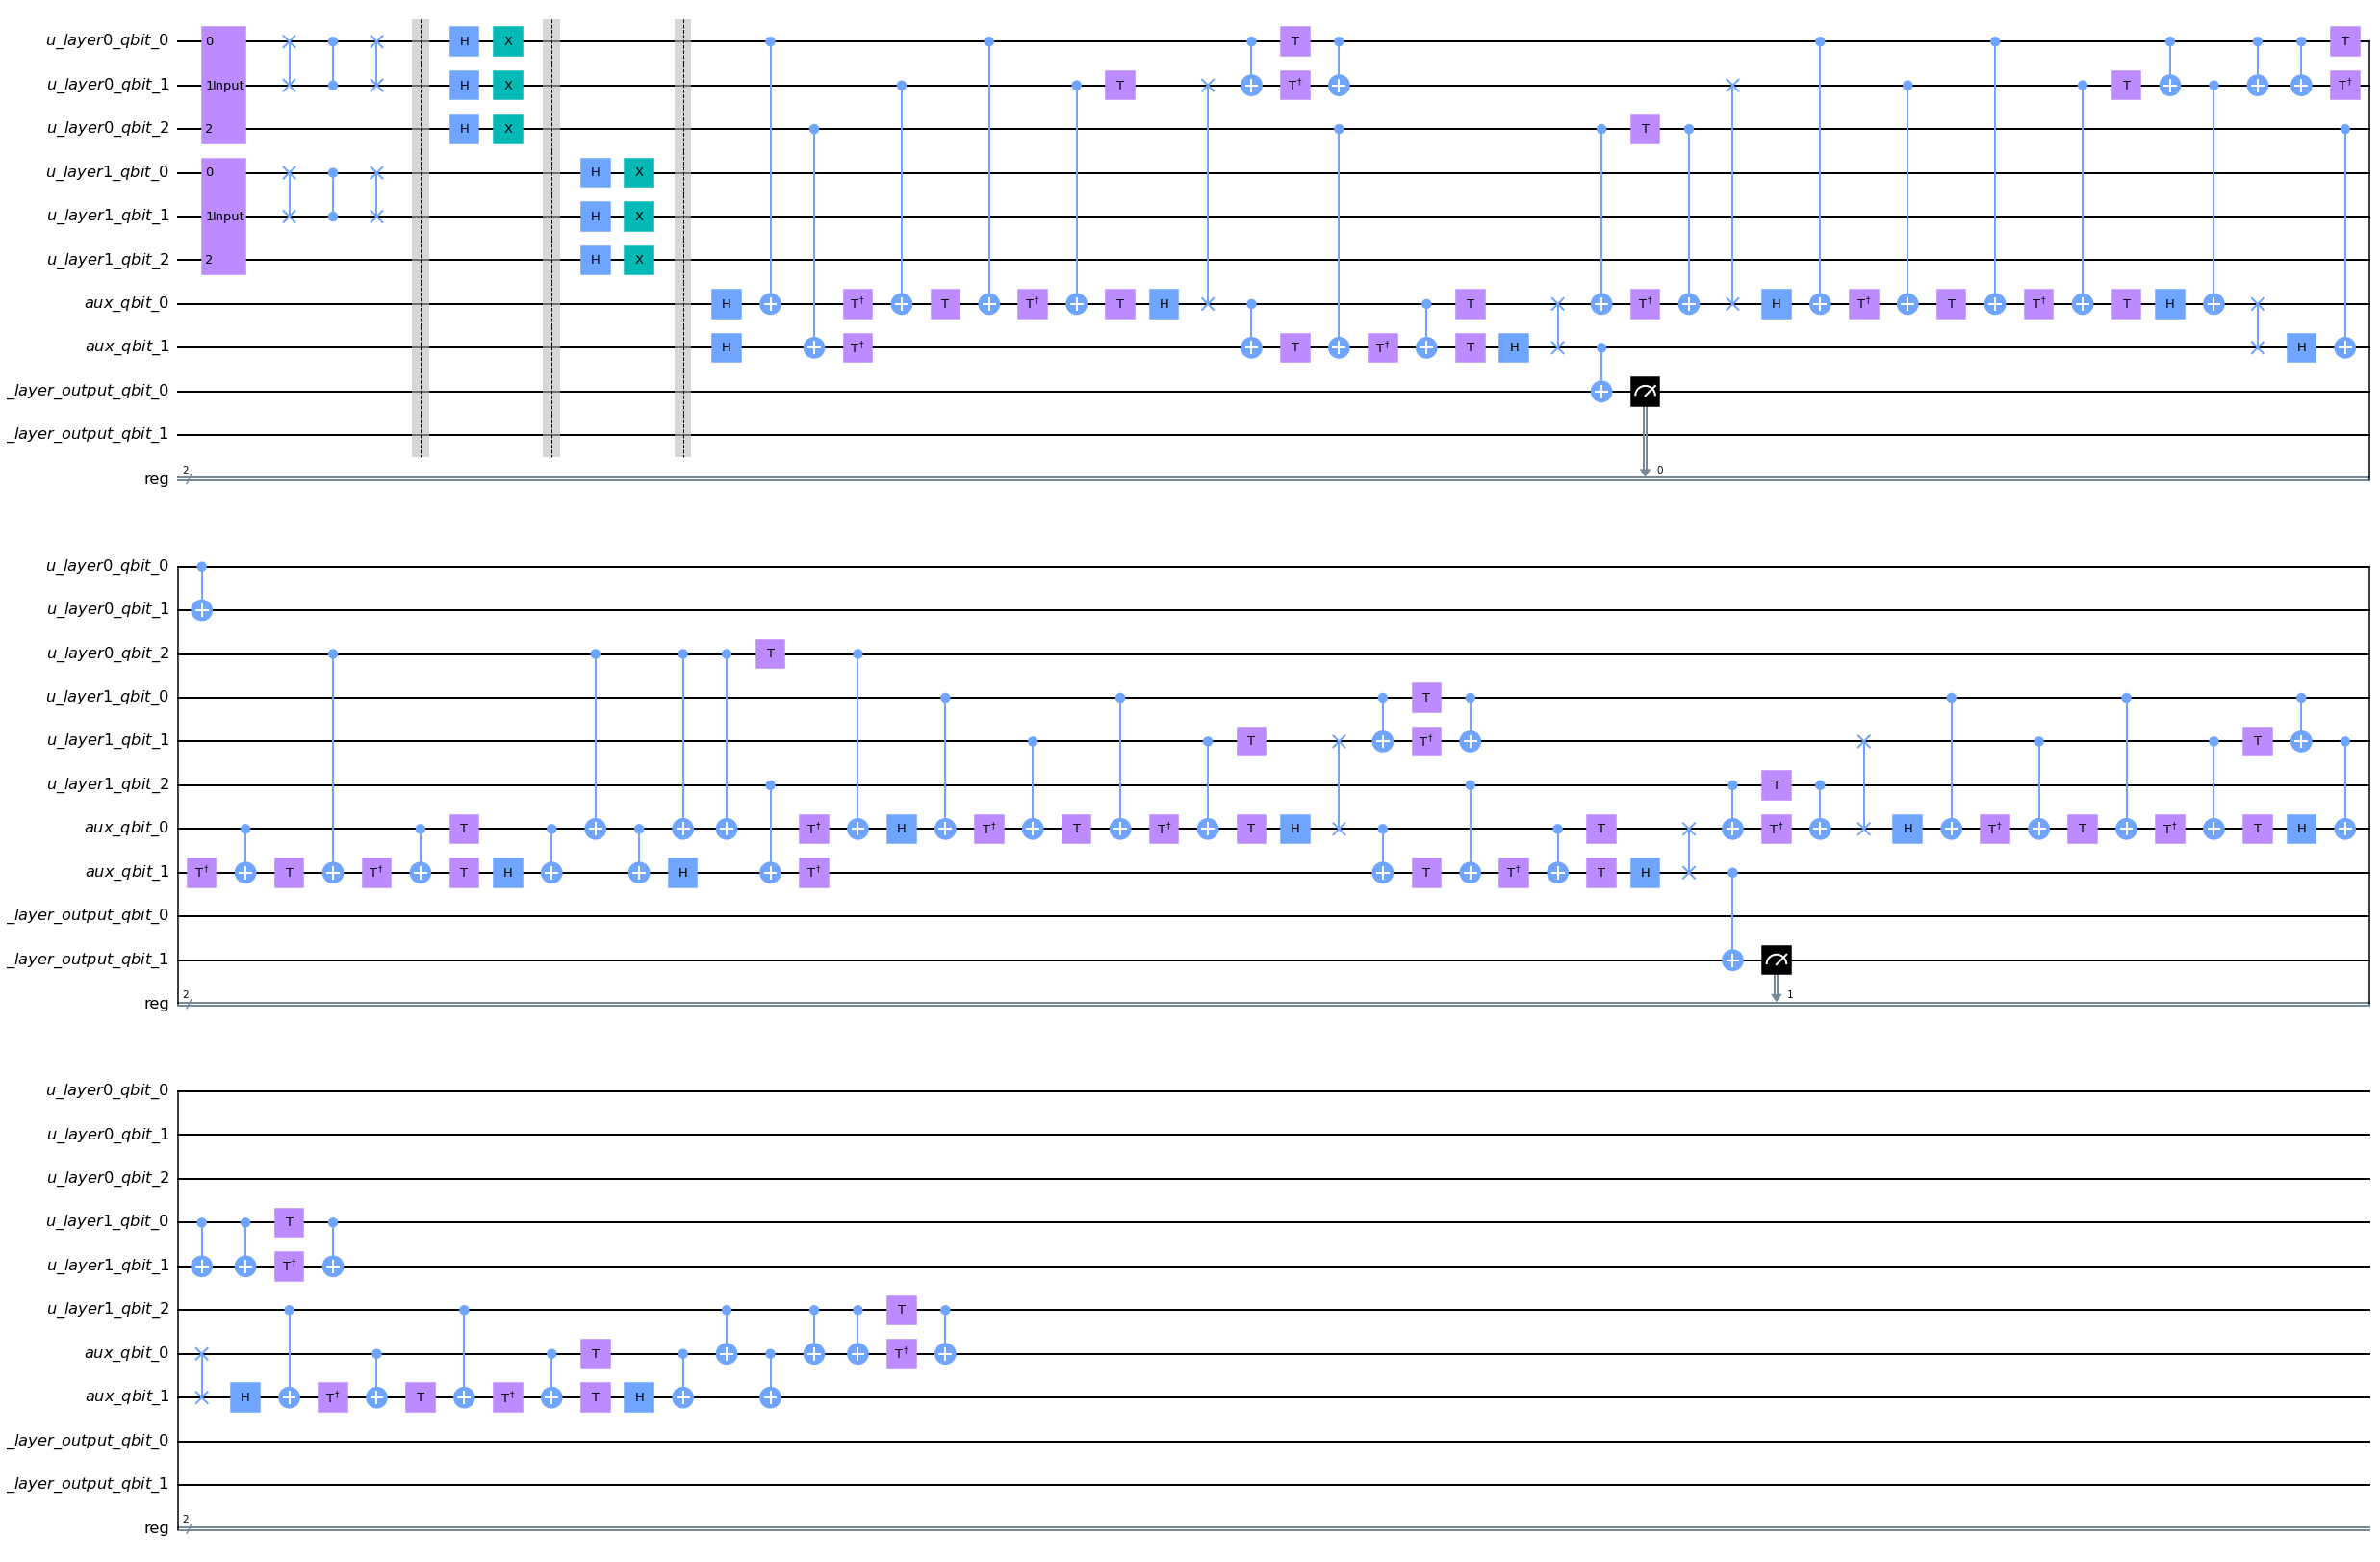

In [30]:
def forward(circuit,quantum_matrix,weight, is_mapping = False):
    #generate u-layer
    #define your input and output number
    u_layer = ULayerCircuit(qubit_num,2) 
    #init circuit
    #add input qubit to your circuit
    inps = u_layer.add_input_qubits(circuit)
    
    aux = u_layer.add_aux(circuit)
    
    #add output qubit to your circuit
    u_layer_out_qubits = u_layer.add_out_qubits(circuit)
    
    #add ulayer to your circuit
    #add ulayer to your circuit
    u_layer.add_weight(circuit,weight,inps,quantum_matrix,aux)


    
    if is_mapping:
        func(circuit,inps,u_layer_out_qubits,aux)
    else:
        u_layer.sum2(circuit,inps,u_layer_out_qubits,aux)
    
    #measure
    c_reg = ClassicalRegister(2,"reg")
    circuit.add_register(c_reg)
    circuit.measure(u_layer_out_qubits[0],c_reg[0])
    circuit.measure(u_layer_out_qubits[1],c_reg[1])
    #get the result

    qc_shots=8192
    opt_class_prob = []
    opt_counts = my_ibmq(circuit,qc_shots,True)
    (opt_mycount,bits) = analyze(opt_counts)
    for b in range(bits):
        opt_class_prob.append(float(opt_mycount[b])/qc_shots)
    return opt_class_prob


    #example of u-layer
i = 0
#transform input_data into u-Mat
input_data = torch.load("./liang_random_data.pt")
quantum_matrix =to_quantum_matrix(input_data[i])
circuit = QuantumCircuit()
# init_weight = torch.cat((init_weight,init_weight),0)
print(init_weight)
prob = forward(circuit,quantum_matrix,init_weight, True)
print("Result :",prob)
circuit.draw('mpl',fold=50)


######################################################



## nas 

In [31]:
import logging
import csv
import numpy as np
import tensorflow as tf
import sys

import matplotlib.pyplot as plt
import copy
import random
from datetime import datetime
import time
import torch
import os

def ema(values):
    """
    Helper function for keeping track of an exponential moving average of a list of values.
    For this module, we use it to maintain an exponential moving average of rewards
    """
    weights = np.exp(np.linspace(-1., 0., len(values)))
    weights /= weights.sum()
    a = np.convolve(values, weights, mode="full")[:len(values)]
    return a[-1]

class Controller(object):
    def __init__(self,config,logger):
        self.graph = tf.Graph()

        self.logger = logger
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.sess = tf.Session(config=config, graph=self.graph)

        self.hidden_units = controller_params['hidden_units']

        self.nn1_search_space = controller_params['sw_space']

        self.nn1_num_para = len(self.nn1_search_space)


        self.num_para = self.nn1_num_para

        self.nn1_beg, self.nn1_end = 0, self.nn1_num_para

        self.para_2_val = {}
        idx = 0
        for hp in self.nn1_search_space:
            self.para_2_val[idx] = hp
            idx += 1



        self.RNN_classifier = {}
        self.RNN_pred_prob = {}
        with self.graph.as_default():
            self.build_controller()

        self.reward_history = []
        self.architecture_history = []
        self.trained_network = {}

        self.explored_info = {}

    def build_controller(self):
        self.logger.info('Building RNN Network')
        # Build inputs and placeholders
        with tf.name_scope('controller_inputs'):
            # Input to the NASCell
            self.child_network_paras = tf.placeholder(tf.int64, [None, self.num_para], name='controller_input')
            # Discounted rewards
            self.discounted_rewards = tf.placeholder(tf.float32, (None,), name='discounted_rewards')
            # WW 12-18: input: the batch_size variable will be used to determine the RNN batch
            self.batch_size = tf.placeholder(tf.int32, [], name='batch_size')

        with tf.name_scope('embedding'):
            self.embedding_weights = []
            # share embedding weights for each type of parameters
            embedding_id = 0
            para_2_emb_id = {}
            for i in range(len(self.para_2_val.keys())):
                additional_para_size = len(self.para_2_val[i])
                additional_para_weights = tf.get_variable('state_embeddings_%d' % (embedding_id),
                                                          shape=[additional_para_size, self.hidden_units],
                                                          initializer=tf.initializers.random_uniform(-1., 1.))
                self.embedding_weights.append(additional_para_weights)
                para_2_emb_id[i] = embedding_id
                embedding_id += 1

            self.embedded_input_list = []
            for i in range(self.num_para):
                self.embedded_input_list.append(
                    tf.nn.embedding_lookup(self.embedding_weights[para_2_emb_id[i]], self.child_network_paras[:, i]))
            self.embedded_input = tf.stack(self.embedded_input_list, axis=-1)
            self.embedded_input = tf.transpose(self.embedded_input, perm=[0, 2, 1])

        logger.info('Building Controller')
        with tf.name_scope('controller'):
            with tf.variable_scope('RNN'):
                nas = tf.contrib.rnn.NASCell(self.hidden_units)
                tmp_state = nas.zero_state(batch_size=self.batch_size, dtype=tf.float32)
                init_state = tf.nn.rnn_cell.LSTMStateTuple(tmp_state[0], tmp_state[1])

                output, final_state = tf.nn.dynamic_rnn(nas, self.embedded_input, initial_state=init_state,
                                                        dtype=tf.float32)
                tmp_list = []
                # print("output","="*50,output)
                # print("output slice","="*50,output[:,-1,:])
                for para_idx in range(self.num_para):
                    o = output[:, para_idx, :]
                    para_len = len(self.para_2_val[para_idx])
                    # len(self.para_val[para_idx % self.para_per_layer])
                    classifier = tf.layers.dense(o, units=para_len, name='classifier_%d' % (para_idx), reuse=False)
                    self.RNN_classifier[para_idx] = classifier
                    prob_pred = tf.nn.softmax(classifier)
                    self.RNN_pred_prob[para_idx] = prob_pred
                    child_para = tf.argmax(prob_pred, axis=-1)
                    tmp_list.append(child_para)
                self.pred_val = tf.stack(tmp_list, axis=1)

        self.logger.info('Building Optimization')
        # with tf.name_scope('Optimization'):
        # Global Optimization composes all RNNs in one, like NAS, where arch_idx = 0

        with tf.name_scope('Optimizer'):
            self.global_step = tf.Variable(0, trainable=False)
            self.learning_rate = tf.train.exponential_decay(0.99, self.global_step, 50, 0.5, staircase=True)
            self.optimizer = tf.train.RMSPropOptimizer(learning_rate=self.learning_rate)
        # self.optimizer = tf.train.AdamOptimizer(learning_rate=0.1)
        with tf.name_scope('Loss'):
            # We seperately compute loss of each predict parameter since the dim of predicting parameters may not be same
            for para_idx in range(self.num_para):
                if para_idx == 0:
                    self.policy_gradient_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
                        logits=self.RNN_classifier[para_idx], labels=self.child_network_paras[:, para_idx])
                else:
                    self.policy_gradient_loss = tf.add(self.policy_gradient_loss,
                                                       tf.nn.sparse_softmax_cross_entropy_with_logits(
                                                           logits=self.RNN_classifier[para_idx],
                                                           labels=self.child_network_paras[:, para_idx]))
                # get mean of loss
            self.policy_gradient_loss /= self.num_para
            self.total_loss = self.policy_gradient_loss
            self.gradients = self.optimizer.compute_gradients(self.total_loss)

            # Gradients calculated using REINFORCE
            for i, (grad, var) in enumerate(self.gradients):
                if grad is not None:
                    # print("aaa",grad)
                    # print("aaa",self.discounted_rewards)
                    # sys.exit(0)
                    self.gradients[i] = (grad * self.discounted_rewards, var)

        with tf.name_scope('Train_RNN'):
            # The main training operation. This applies REINFORCE on the weights of the Controller
            # self.train_operation[arch_idx][pip_idx] = self.optimizer[arch_idx][pip_idx].apply_gradients(self.gradients[arch_idx][pip_idx], global_step=self.global_step[arch_idx][pip_idx])
            # self.train_operation = self.optimizer.minimize(self.total_loss)
            self.train_operation = self.optimizer.apply_gradients(self.gradients)
            self.update_global_step = tf.assign(self.global_step, self.global_step + 1, name='update_global_step')

        self.logger.info('Successfully built controller')

    def child_network_translate(self, child_network):
        dnn_out = np.zeros_like(child_network)
        for para_idx in range(self.num_para):
            dnn_out[0][para_idx] = (self.para_2_val[para_idx][child_network[0][para_idx]])
        return dnn_out

    def generate_child_network(self, child_network_architecture):
        with self.graph.as_default():
            feed_dict = {
                self.child_network_paras: child_network_architecture,
                self.batch_size: 1
            }
            rnn_out = self.sess.run(self.RNN_pred_prob, feed_dict=feed_dict)
            predict_child = np.array([[0] * self.num_para])
            # random.seed(datetime.now())
            for para_idx, prob in rnn_out.items():
                predict_child[0][para_idx] = np.random.choice(range(len(self.para_2_val[para_idx])), p=prob[0])
            hyperparameters = self.child_network_translate(predict_child)
            return predict_child, hyperparameters

    def plot_history(self, history, ylim=(-1, 1), title="reward"):
        x = list(range(len(history)))
        y = history
        plt.plot(x, y)
        # plt.ylim(ylim)
        plt.title(title)
        plt.show()
    
    def set_calc_acc_func(self,func):
        self.caculate_err = func

    def para2interface_NN(self, Para_NN1):
        # Weiwen 01-24: Build NN using explored hyperparamters, return Network
        Para_NN1 = torch.tensor(Para_NN1,dtype= torch.double)
        return 1 - self.caculate_err(Para_NN1)

    def global_train(self):
        with self.graph.as_default():
            self.sess.run(tf.global_variables_initializer())
        step = 0
        total_rewards = 0
        child_network = np.array([[0] * self.num_para], dtype=np.int64)

        for episode in range(controller_params['max_episodes']):
            self.logger.info(
                '=-=-==-=-==-=-==-=-==-=-==-=-==-=-=>Episode {}<=-=-==-=-==-=-==-=-==-=-==-=-==-=-='.format(episode))
            step += 1
            episode_reward_buffer = []
            arachitecture_batch = []

            if episode % 50 == 0 and episode != 0:
                print("Process:", str(float(episode) / controller_params['max_episodes'] * 100) + "%", file=sys.stderr)
                # self.plot_history(self.reward_history, ylim=(min(self.reward_history)-0.01, max(self.reward_history)+0.01))

            for sub_child in range(controller_params["num_children_per_episode"]):
                # Generate a child network architecture
                child_network, hyperparameters = self.generate_child_network(child_network)

                DNA_NN1 = child_network[0][self.nn1_beg:self.nn1_end]


                Para_NN1 = hyperparameters[0][self.nn1_beg:self.nn1_end]
                

                str_NN1 = " ".join(str(x) for x in Para_NN1)
                str_NNs = str_NN1



                self.logger.info('=====>Step {}/{} in episode {}: HyperParameters: {} <====='.format(sub_child, \
                                                                                                controller_params[
                                                                                                    "num_children_per_episode"],
                                                                                                episode,
                                                                                                hyperparameters))

                if str_NNs in self.explored_info.keys():
                    accuracy = self.explored_info[str_NNs][0]
                    reward = self.explored_info[str_NNs][1]
                    

                else:
                    print(Para_NN1)
                    accuracy = self.para2interface_NN(Para_NN1)
                    reward = accuracy

                    self.explored_info[str_NNs] = {}
                    self.explored_info[str_NNs][0] = accuracy
                    self.explored_info[str_NNs][1] = reward

                self.logger.info("====================Results=======================")
                self.logger.info("--------->NN: {}, Accuracy: {}".format(str_NNs, accuracy))
                self.logger.info("--------->Reward: {}".format(reward))
                self.logger.info("=" * 50)

                episode_reward_buffer.append(reward)
                identified_arch = np.array(
                    list(DNA_NN1))
                arachitecture_batch.append(identified_arch)

            current_reward = np.array(episode_reward_buffer)

            mean_reward = np.mean(current_reward)
            self.reward_history.append(mean_reward)
            self.architecture_history.append(child_network)
            total_rewards += mean_reward

            baseline = ema(self.reward_history)
            last_reward = self.reward_history[-1]
            # rewards = current_reward - baseline
            rewards = [last_reward - baseline]

            feed_dict = {
                self.child_network_paras: arachitecture_batch,
                self.batch_size: len(arachitecture_batch),
                self.discounted_rewards: rewards
            }

            with self.graph.as_default():
                _, _, loss, lr, gs = self.sess.run(
                    [self.train_operation, self.update_global_step, self.total_loss, self.learning_rate,
                     self.global_step], feed_dict=feed_dict)

            self.logger.info('=-=-=-=-=-=>Episode: {} | Loss: {} | LR: {} | Mean R: {} | Reward: {}<=-=-=-=-='.format(
                episode, loss, (lr, gs), mean_reward, rewards))


        # print('reward_history',self.reward_history)
        # print('str_NNs',str_NNs)
        # self.plot_history(self.reward_history, ylim=(min(self.reward_history)-0.01, max(self.reward_history)-0.01))

        return Para_NN1

## GA

In [32]:
DNA_SIZE = 8
POP_SIZE = 10
CROSSOVER_RATE = 0.8
MUTATION_RATE = 0.005
N_GENERATIONS = 10

class GA(object):

    def setF(self,func):
        self.F = func


    def get_fitness(self,pop):
        weight = self.translateDNA(pop)
        pred = []
        for i in range(len(weight)):
            print(weight[i])
            pred.append(1 - self.F(weight[i]))
        return (pred - np.min(pred)) + 1e-3 #减去最小的适应度是为了防止适应度出现负数，通过这一步fitness的范围为[0, np.max(pred)-np.min(pred)],最后在加上一个很小的数防止出现为0的适应度


    def translateDNA(self,pop): #pop表示种群矩阵，一行表示一个二进制编码表示的DNA，矩阵的行数为种群数目
        weights = []
        for i in range(np.size(pop,0)):
            weight =  torch.tensor(pop[i],dtype= torch.double)
            weights.append(weight)
        return weights


    def crossover_and_mutation(self,pop, CROSSOVER_RATE = 0.8):
        new_pop = []
        for father in pop:        #遍历种群中的每一个个体，将该个体作为父亲
            child = father        #孩子先得到父亲的全部基因（这里我把一串二进制串的那些0，1称为基因）
            if np.random.rand() < CROSSOVER_RATE:            #产生子代时不是必然发生交叉，而是以一定的概率发生交叉
                mother = pop[np.random.randint(POP_SIZE)]    #再种群中选择另一个个体，并将该个体作为母亲
                cross_points = np.random.randint(low=0, high=DNA_SIZE*2)    #随机产生交叉的点
                child[cross_points:] = mother[cross_points:]        #孩子得到位于交叉点后的母亲的基因
            self.mutation(child)    #每个后代有一定的机率发生变异
            new_pop.append(child)

        return new_pop

    def mutation(self,child, MUTATION_RATE=0.003):
        if np.random.rand() < MUTATION_RATE:                 #以MUTATION_RATE的概率进行变异
            mutate_point = np.random.randint(0, DNA_SIZE*2)    #随机产生一个实数，代表要变异基因的位置
            child[mutate_point] = child[mutate_point]^1     #将变异点的二进制为反转

    def select(self,pop, fitness):    # nature selection wrt pop's fitness
        idx = np.random.choice(np.arange(POP_SIZE), size=POP_SIZE, replace=True,
                               p=(fitness)/(fitness.sum()) )
        return pop[idx]

    def print_info(self,pop):
        fitness = self.get_fitness(pop)
        max_fitness_index = np.argmax(fitness)
        print("max_fitness:", fitness[max_fitness_index])
        weights = self.translateDNA(pop)
        print("best gene：", pop[max_fitness_index])
        print("weights:", weights[max_fitness_index])

        return weights[max_fitness_index],fitness[max_fitness_index]

## train and test

In [33]:
input_data = torch.load("./liang_random_data.pt")
target = torch.load("./liang_random_target.pt")
target = target.int()
correct_weight = torch.load("./liang_weight.pt")
# correct_weight = torch.cat((correct_weight,correct_weight),0)
print('correct_weight:',correct_weight)

train_rate = 0.5
input_data_num = target.shape[0]
train_num = int(input_data_num *train_rate)
is_train = False
search_model = 'random' #random/traverse/rl



def calculate_error_rate(weight):
    global input_data
    global target
    global correct_weight
    global train_num
    
    weight = weight.view(2,-1)
    circuit_result = []
    for i in range(train_num):
        quantum_matrix =to_quantum_matrix(input_data[i])
        circuit = QuantumCircuit()   
        prob = forward(circuit,quantum_matrix,weight,False)
        if prob[0] >= prob[1] :
            circuit_result.append(1)
        else:
            circuit_result.append(-1)
    circuit_result_tensor = torch.tensor(circuit_result,dtype=torch.double)
    circuit_result_tensor = circuit_result_tensor.int()
    error_num = (circuit_result_tensor != target[0:train_num]).sum()
    error_rate = float(error_num)/(train_num+0.0000000001)
    return error_rate

if is_train:
    if search_model == 'random':
        weight_list = []
        acc_list = []
        itor_times = 50
        for i in range(itor_times):
            rand_weight = sign(torch.rand(2,int(math.pow(2,qubit_num)), dtype= torch.double))
            acc = 1- calculate_error_rate(rand_weight)
            weight_list.append(rand_weight)
            acc_list.append(acc)
        good_weight = weight_list[acc_list.index(max(acc_list))]
        print("good_weight:",good_weight,',highest accuracy:',max(acc_list))

    elif search_model == 'traverse':
        acc_list = []
        traverse_mat = get_traverse_weight(int(math.pow(2,qubit_num)))
        traverse_mat_tensor = torch.tensor(traverse_mat,dtype=torch.double)
        traverse_weight_tensor = traverse_mat_tensor.new(traverse_mat_tensor.size())
        traverse_weight_tensor[traverse_mat_tensor == 0] =-1
        traverse_weight_tensor[traverse_mat_tensor == 1] = 1
        for i in range(traverse_weight_tensor.shape[0]):
            # print(traverse_weight_tensor[i].view(1,-1))
            acc = 1- calculate_error_rate(traverse_weight_tensor[i])
            acc_list.append(acc)           
        good_weight = traverse_weight_tensor[acc_list.index(max(acc_list))]
        print("good_weight:",good_weight,',best accuracy:',max(acc_list))
    
    elif search_model == 'rl':
        logger = logging.getLogger(__name__)
        controller_params = {
            "sw_space": ([-1,+1],[-1,+1],[-1,+1],[-1,+1],[-1,+1],[-1,+1],[-1,+1],[-1,+1],
                         [-1,+1],[-1,+1],[-1,+1],[-1,+1],[-1,+1],[-1,+1],[-1,+1],[-1,+1]),
            # dataflow 1, dataflow 2, PE for d1, BW for d1
            'max_episodes': 50,
            "num_children_per_episode": 1,
            'hidden_units': 35,
        }

        seed = 0
        torch.manual_seed(seed)
        random.seed(seed)
        logging.basicConfig(stream=sys.stdout,
                            level=logging.CRITICAL,
                            format='%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
        
        print("Nas Begin")
        controller = Controller(controller_params,logger)
        controller.set_calc_acc_func(calculate_error_rate)
        good_weight = controller.global_train()
        good_weight = torch.tensor(good_weight,dtype = torch.double)
        print("good_weight:",good_weight)
    elif search_model == 'ga':
        ga = GA()
        ga.setF(calculate_error_rate)
        pop = np.random.randint(2, size=(POP_SIZE, DNA_SIZE*2)) #matrix (POP_SIZE, DNA_SIZE)
        for _ in range(N_GENERATIONS):#迭代N代
            weights = ga.translateDNA(pop)
            pop = np.array(ga.crossover_and_mutation(pop, CROSSOVER_RATE))
            fitness = ga.get_fitness(pop)
            pop = ga.select(pop, fitness) #选择生成新的种群
        
        good_weight ,best_acc = ga.print_info(pop)
        print("good_weight:",good_weight,',best accuracy:',best_acc)

    #test
    circuit_result = []
    for i in range(train_num,input_data_num):
        quantum_matrix =to_quantum_matrix(input_data[i])
    
        circuit = QuantumCircuit()
        prob = forward(circuit,quantum_matrix,good_weight.view(2,-1),False)

        if prob[0] >= prob[1] :
            circuit_result.append(1)
        else:
            circuit_result.append(-1)
    
    circuit_result_tensor = torch.tensor(circuit_result,dtype=torch.double)
    circuit_result_tensor = circuit_result_tensor.int()
    error_num = (circuit_result_tensor != target[train_num:input_data_num]).sum()
    
    print("error_num :",error_num)
    print("error_rate:",float(error_num)/(input_data_num - train_num))


correct_weight: tensor([[-1., -1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1., -1., -1.]], dtype=torch.float64)


In [35]:
#test
circuit_result = []
for i in range(train_num,input_data_num):
    quantum_matrix =to_quantum_matrix(input_data[i])

    circuit = QuantumCircuit()   
    prob = forward(circuit,quantum_matrix,correct_weight,True)

    if prob[0] >= prob[1] :
        circuit_result.append(1)
    else:
        circuit_result.append(-1)

circuit_result_tensor = torch.tensor(circuit_result,dtype=torch.double)
circuit_result_tensor = circuit_result_tensor.int()
error_num = (circuit_result_tensor != target[train_num:input_data_num]).sum()

print("error_num :",error_num)
print("error_rate:",float(error_num)/(input_data_num - train_num))

error_num : tensor(16)
error_rate: 0.32
